In [3]:
# pip install ectoolkits
from ectoolkits.structures.slab import Slab
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.visualize import view

# water density

The following codes are for preprocessing the trajectory (AIMD or DPMD). Not so automatic.

First, the structures in the trajectory must be centered to the water.

In [117]:
prefix = Path("../00.sno2_traj/")
traj = read(prefix/"sno2-water.xyz", index=':')
stc_translation = [0.0, 0.0, -6.95]
for stc in traj:
    cell = [12.745532, 13.399023, 40.985034]
    stc.set_cell(cell)
    stc.set_pbc([True, True, True])
    stc.translate(stc_translation)
    stc.wrap()

write(prefix/"sno2-water-centered.xyz", traj)

To comupute the water density, we must obtain the atom indices of the surface atoms and the indices of the oxygen atoms of water molecules. For the time being, I obtain the indices by checking the z positions of the atoms.

In [118]:
traj = read(prefix/"sno2-water-centered.xyz", index=':')
stc = traj[0].copy()

stc.set_cell(cell)
stc.set_pbc([True, True, True])
stc.wrap()
write(prefix/"first_frame.cif", stc)
stc = Slab(stc)
surf1_idx = stc.find_idx_from_range(zmin=6.2, zmax=7.2, element='Sn')
surf2_idx = stc.find_idx_from_range(zmin=33.702, zmax=34.702, element='Sn')
O_idx = stc.find_idx_from_range(zmin=7.2, zmax=33.702, element='O')

This part is to obtain the water density

In [121]:
from ectoolkits.analysis.atom_density import AtomDensity

# from
inp_dict={
     "xyz_file": prefix/"sno2-water-centered.xyz",
     "cell": cell,
     "surf2": surf2_idx,
     "surf1": surf1_idx,
     "density_type":[
         {
             "element": "O",
             "idx_method": "manual",
             "idx_list": O_idx,
             "density_unit": "water",
             "dz": 0.05,
             "name": "./water_density"
             }
         ]
 }
ad = AtomDensity(inp_dict)
ad.run()

ToolKit: Perform Atom Density Analysis
ToolKit: Read Structure File: ../00.sno2_traj/sno2-water-centered.xyz
ToolKit: Read the Cell Info: [12.745532, 13.399023, 40.985034]
ToolKit: Read Surface 1 Atoms Index: [597, 602, 603, 605, 607, 614, 621, 626, 632, 634, 641, 649, 657, 665, 666, 667]
ToolKit: Read Surface 2 Atoms Index: [589, 591, 601, 615, 620, 622, 623, 627, 630, 631, 640, 643, 650, 651, 659, 668]
ToolKit: Now Start Reading Structures
ToolKit: ----------------------------
ToolKit: Reading Structures is Finished
ToolKit: Read Frame Number: 10001
ToolKit: Read Atom Number: 669
ToolKit: START GETTING ATOM DENSITY
ToolKit: ----------------------------
ToolKit: Density Profile Data Save to ./water_density.dat


Plot for water density

/var/folders/8l/57flydkd1g1cnt4w1sbpzy080000gn/T/ipykernel_8199/965169988.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


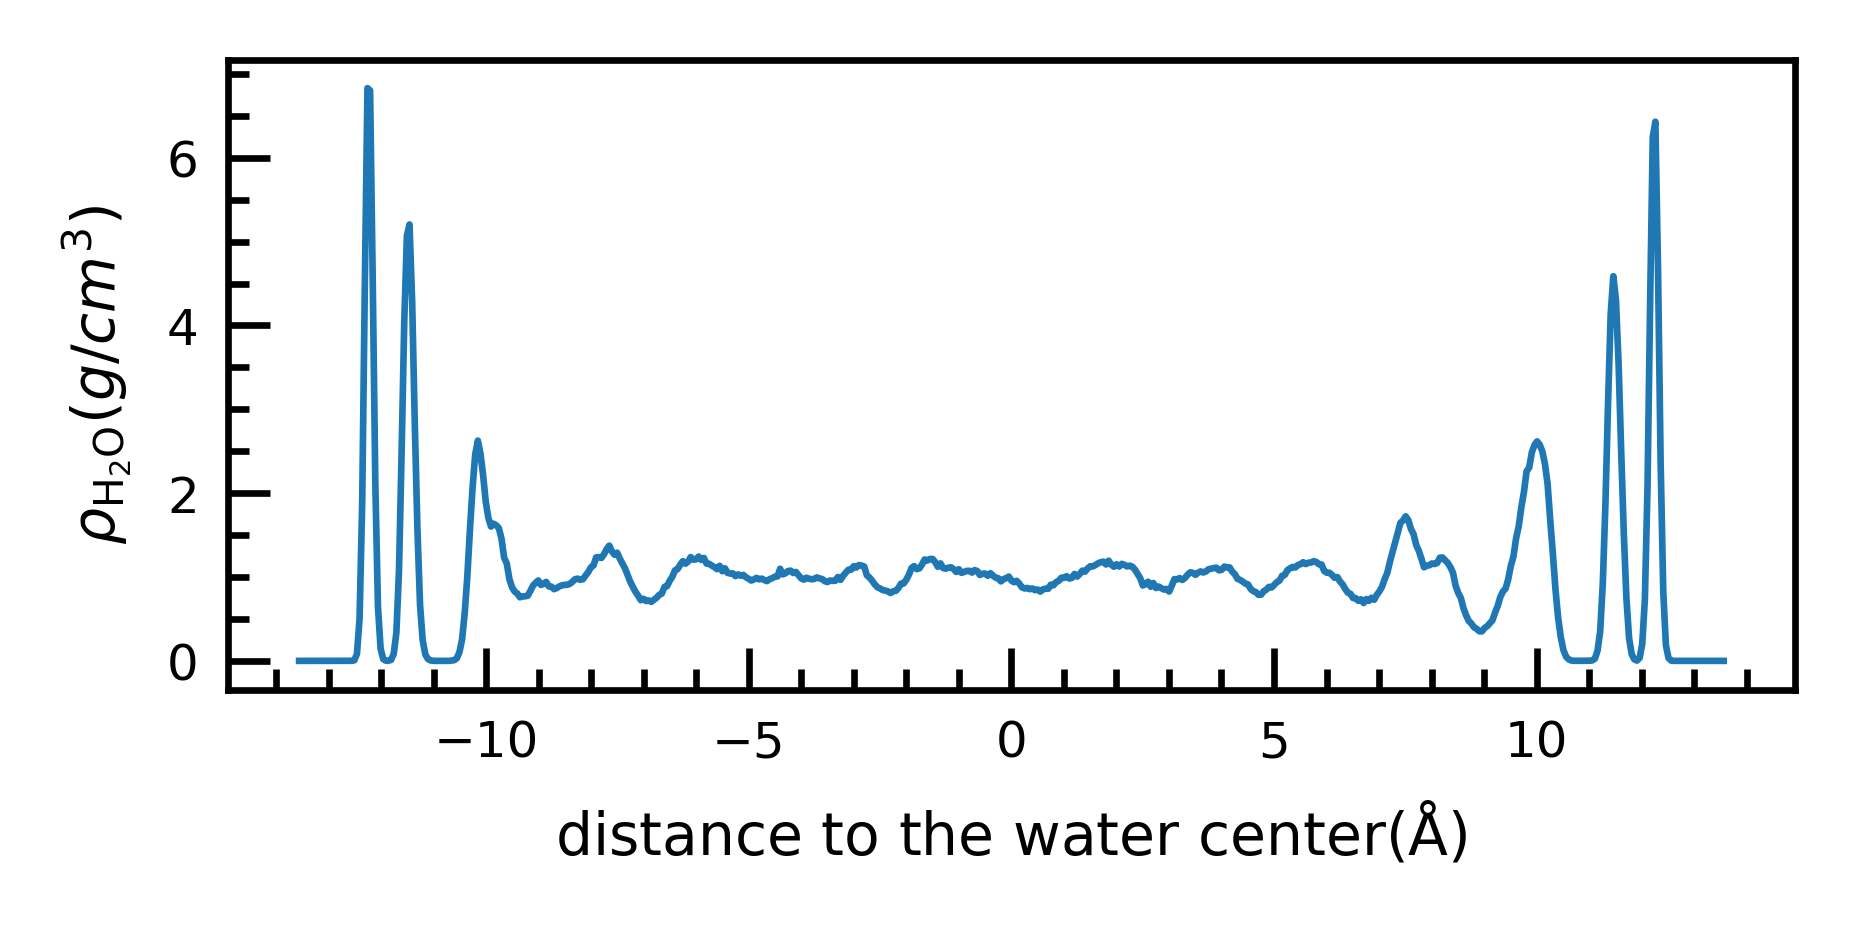

In [122]:
# from ase.visualize.plot import plot_atoms
z, water_density = np.loadtxt("./water_density.dat", unpack=True)
z = z - np.median(z)


plt.style.use('cp2kdata.matplotlibstyle.jcp')
row = 2
col = 1
fig = plt.figure(figsize=(3.37*col, 1.5*row), dpi=600, facecolor='white')
gs = fig.add_gridspec(row,col)

# ax  = fig.add_subplot(gs[0])
# first_frame = read(prefix/"first_frame.cif")
# xlim = ax.get_xlim()
# cell = first_frame.get_cell()
# plot_atoms(first_frame, ax, radii=0.8, rotation=('90x,90y,90z'))


ax  = fig.add_subplot(gs[0])
ax.plot(z, water_density)
ax.set_xlabel('distance to the water center'+r'($\mathrm{\AA}$)')
ax.set_ylabel(r'$\rho_{\mathrm{H_2O}}$' + r'$(g/cm^3)$')

#ax.legend()
fig.show()

# Proton Transfer